In [1]:
%matplotlib inline
import pyodbc
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

sn.set_context('notebook')

# Phytoplankton database

**Note:** Because NIVA uses the 32-bit version of Access, this notebook must be run using **32-bit** Python.

## 1. Connect to Access db

In [2]:
# Connect to db
db_path = (r'C:\Data\James_Work\Staff\Birger_S\Phytoplankton_DB'
           r'\Phytoplankton.accdb')
con_str = 'Driver={Microsoft Access Driver (*.mdb, *.accdb)};Dbq=' + db_path
acc_eng = pyodbc.connect(con_str, autocommit=True)

## 2. Extract data

### 2.1. Total biovolume per sample

In [3]:
# Get total biovol per water sample
sql = ("SELECT sampleid, "
       "  SUM(bio_volume) AS bio_vol "
       "FROM t_Phytoplankton "
       "GROUP BY sampleid")
phy_df = pd.read_sql(sql, acc_eng)
phy_df.head()

,sampleid,bio_vol
0,1,1179.64985
1,2,367.65250
2,3,320.64405
3,4,212.23445
4,5,188.75070


### 2.2. Nutrient concentrations per sample

In [4]:
# Get tot-N and tot-P for water samples
# NB: Some samples have duplicated pars - average for now
sql = ("SELECT sampleid, "
       "  parameterid, "
       "  AVG(param_value) AS val "
       "FROM q_Chemistry "
       "WHERE parameterid IN ('N-TOT', 'P-TOT') "
       "GROUP BY sampleid, parameterid")
wc_df = pd.read_sql(sql, acc_eng)

# Pivot
wc_df.set_index(['sampleid', 'parameterid'], inplace=True)
wc_df = wc_df.unstack(level='parameterid')
wc_df.reset_index(inplace=True)
wc_df.index.name = ''
wc_df.columns = (list(wc_df.columns.get_level_values(0)[:1]) + 
                 list(wc_df.columns.get_level_values(1)[1:]))
wc_df.head()

,sampleid,N-TOT,P-TOT
,,,
0,1,1678.0,14.76305
1,2,199.0,19.02605
2,3,299.0,10.14480
3,4,308.0,19.38130
4,5,285.0,8.36855


### 2.3. Combine biological and chemical datasets

In [5]:
# Join data
df = pd.merge(phy_df, wc_df, how='inner', on='sampleid')

# Drop NA
df.dropna(how='any', inplace=True)

# ln transform
df = np.log(df)

df.head()

,sampleid,bio_vol,N-TOT,P-TOT
0,0.000000,7.072973,7.425358,2.692127
1,0.693147,5.907138,5.293305,2.945809
2,1.098612,5.770332,5.700444,2.316961
3,1.386294,5.357692,5.730100,2.964309
4,1.609438,5.240427,5.652489,2.124481


## 3. Regression

### 3.1. Simple OLS

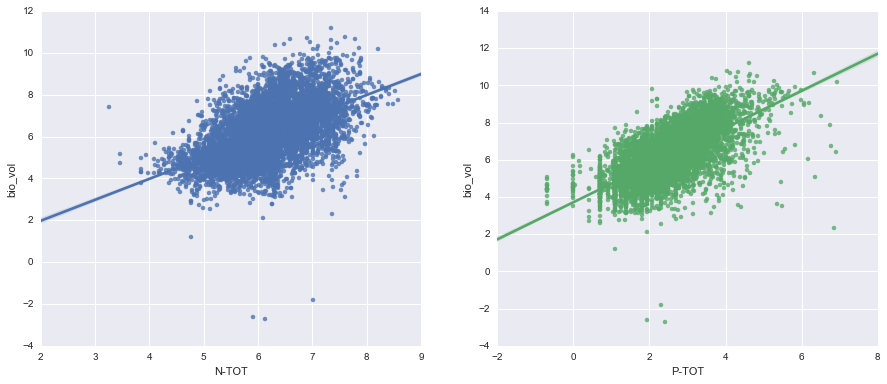

In [6]:
# Plot biovol vs N and P
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sn.regplot(x='N-TOT', y='bio_vol', data=df, ax=axes[0])
sn.regplot(x='P-TOT', y='bio_vol', data=df, ax=axes[1])

### 3.2. Multiple linear regression

In [7]:
def ols(df, mod_str):
    """ OLS results for best lasso model.
    
    Args:
        df:      Dataframe
        mod_str: Patsy model string
        
    Returns:
        Model object
    """
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    # OLS regression
    model = smf.ols(mod_str, data=df).fit()

    print model.summary()
    
    return model

def plot_model(df, model, resp_var):
    """ Simple plots of fitted values and residuals.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    axes[0].plot(df[resp_var], model.fittedvalues, 'ro')
    axes[0].plot(df[resp_var], df[resp_var], 'k-', label='1:1 line')
    axes[0].set_title('Adjusted R2=%.2f' % model.rsquared_adj, fontsize=18)
    axes[0].set_xlabel('Observed', fontsize=16)
    axes[0].set_ylabel('Modelled', fontsize=16)
    axes[0].legend(loc='lower right', fontsize=16)
    
    sn.distplot(model.resid, ax=axes[1])
    axes[1].set_title('Residuals', fontsize=18)
    axes[1].set_xlabel('Residual', fontsize=16)
    axes[1].set_ylabel('Normalised frequency', fontsize=16)
    
    plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                bio_vol   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     3564.
Date:                Mon, 26 Feb 2018   Prob (F-statistic):               0.00
Time:                        15:51:25   Log-Likelihood:                -10718.
No. Observations:                7736   AIC:                         2.144e+04
Df Residuals:                    7733   BIC:                         2.146e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.3151      0.106     21.815      0.0

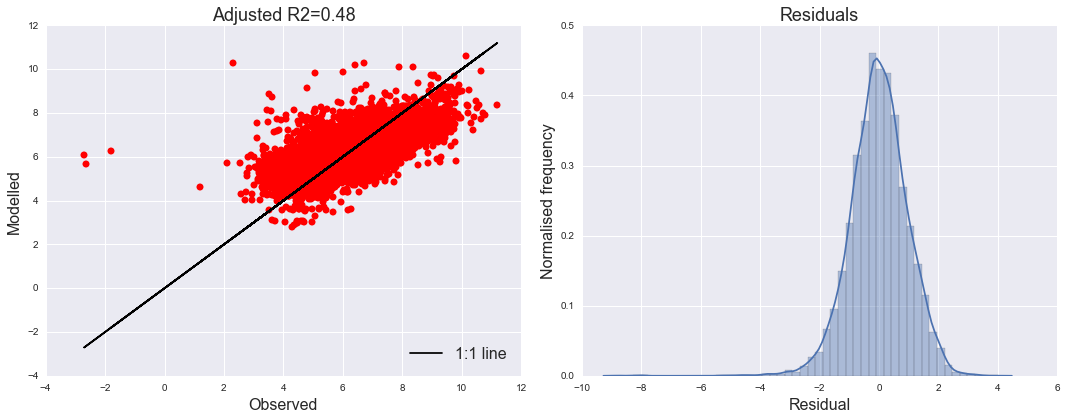

In [8]:
# MLR
mod = ols(df, 'bio_vol ~ Q("N-TOT")+Q("P-TOT")')
plot_model(df, mod, 'bio_vol')

## 4. Generate datset for further exploration

During a meeting on 26/02/2018, we decided to extract a "full", species-level dataset from the Access database for further exploration. The dataset should contain:

 * Station details (station codes, geographic co-ordinates)
 * Water sample details (dates, sample depths)
 * Phytoplankton results (Rubin codes, taxon names, counts, biovolumnes etc.)
 * Further taxonomic information (genus family etc., plus whether a taxon is heterotrophic or not)
 * Water chemistry
 
### 4.1. Extract biological data

In [9]:
# Get all the bio data of interest
sql = ("SELECT a.stationid, "
       "  a.station, "
       "  a.stasjonskode, "
       "  a.longitude, "
       "  a.latitude, "
       "  b.sampleid, "
       "  b.sampledate, "
       "  b.depth_1, "
       "  b.depth_2, "
       "  c.rubin_code, "
       "  d.rebeccaid, "
       "  c.taxon, "
       "  e.kingdom, "
       "  e.phyllum, "
       "  e.class, "
       "  e.order, "
       "  e.family, "
       "  e.genus, "
       "  e.species, "
       "  e.heterotrophic, "
       "  c.number, "
       "  c.factor, "
       "  c.taxon_volume, "
       "  c.bio_volume "
       "FROM t_Stations a, "
       "  t_Sample b, "
       "  t_Phytoplankton c, "
       "  q_Rubin_to_REBECCA d, "
       "  q_PP_Taxonomy_NO e "
       "WHERE a.stationid = b.stationid "
       "AND b.sampleid    = c.sampleid "
       "AND c.rubin_code  = d.rubin_kode "
       "AND d.rebeccaid   = e.rebeccaid "
       "ORDER BY a.stationid, "
       "  b.sampledate, "
       "  b.depth_1, "
       "  b.depth_2")    
phy_df = pd.read_sql(sql, acc_eng)

print 'Total number of records:', len(phy_df)
phy_df.head()

Total number of records: 541915


,stationid,station,stasjonskode,longitude,latitude,sampleid,sampledate,depth_1,depth_2,rubin_code,...,class,order,family,genus,species,heterotrophic,number,factor,taxon_volume,bio_volume
0,1,Vinsternesvatnet,Vinsternesvatnet1,8.33704,63.23658,12826,2013-07-09,0.0,4.0,RHOD NAN,...,Cryptophyceae,Pyrenomonadales,Geminigeraceae,Plagioselmis,nannoplanctica,None,1.0,4006.0,150.0,0.600900
1,1,Vinsternesvatnet,Vinsternesvatnet1,8.33704,63.23658,12826,2013-07-09,0.0,4.0,GYMNODI1,...,Dinophyceae,Gymnodiniales,Gymnodiniaceae,Gymnodinium,sp.,None,1.0,801.0,1050.0,0.841050
2,1,Vinsternesvatnet,Vinsternesvatnet1,8.33704,63.23658,12826,2013-07-09,0.0,4.0,GYRO COR,...,Pyramimonadophyceae,Pyramimonadales,Polyblepharidaceae,Gyromitus,cordiformis,Yes,1.0,801.0,525.0,0.420525
3,1,Vinsternesvatnet,Vinsternesvatnet1,8.33704,63.23658,12826,2013-07-09,0.0,4.0,KATA OVA,...,Katablepharidophyceae,Katablephariales,Katablepharidaceae,Katablepharis,ovalis,Yes,2.0,4006.0,90.0,0.721080
4,1,Vinsternesvatnet,Vinsternesvatnet1,8.33704,63.23658,12826,2013-07-09,0.0,4.0,MALLOMOZ,...,Synurophyceae,Synurales,Mallomonadaceae,Mallomonas,sp.,None,4.0,801.0,750.0,2.403000


### 4.2. Extract chemistry data

The Access database already includes a summary table for water chemistry. The code below reads this and then restructures it.

In [10]:
# Read wtaer chem
sql = ("SELECT sampleid, "
       "  parameterid, "
       "  param_value, "
       "  param_unit "
       "FROM q_chemistry")
wc_df = pd.read_sql(sql, acc_eng)

print 'Total number of water chemistry measurements:', len(wc_df)
wc_df.head()

Total number of water chemistry measurements: 79539


,sampleid,parameterid,param_value,param_unit
0,111,ALK,0.154,mmol/l
1,111,FARGE,29.000,mg/l Pt
2,111,KLFA,4.600,µg/l
3,111,KOND,3.040,mS/m
4,111,N-NO3,2.500,µg/l N


An initial attempt to pivot this table produced errors regarding duplicates. Let's check for duplication.

In [11]:
dup_df = wc_df[wc_df.duplicated(subset=['sampleid', 
                                        'parameterid'], keep=False)]

print 'Total number of duplicates:', len(dup_df)
dup_df.head(10)

Total number of duplicates: 1264


,sampleid,parameterid,param_value,param_unit
15502,2545,KLFA,5.5,µg/l
15503,2545,KLFA,5.6,µg/l
15504,2545,KLFA,5.7,µg/l
15505,2545,KLFA,5.8,µg/l
15506,2545,KLFA,6.0,µg/l
15519,2546,KLFA,9.1,µg/l
15520,2546,KLFA,10.4,µg/l
15521,2546,KLFA,12.5,µg/l
15522,2546,KLFA,14.9,µg/l
15523,2546,KLFA,15.4,µg/l


In [12]:
# Get parameters with duplicated data
dup_df['parameterid'].unique()

array([u'KLFA', u'TURB', u'KOND', u'N-TOT', u'P-TOT', u'ALK', u'CA', u'CL',
       u'DIP', u'K', u'MG', u'NA', u'N-NO3', u'PH', u'SO4', u'MICYS',
       u'Phycocyanin', u'DOC', u'P-PO4', u'N-NH4'], dtype=object)

So there are quite a lots of water samples with duplicated chemistry data. For now, I will simply average all the duplicated values, but need to **check this with Birger**.

In [13]:
# Combine param and unit cols
wc_df['par_unit'] = wc_df['parameterid'] + '#' + wc_df['param_unit']
del wc_df['parameterid'], wc_df['param_unit']

# Average duplicates
wc_df = wc_df.groupby(['sampleid', 
                       'par_unit']).agg('mean').reset_index()

# Pivot
wc_df.set_index(['sampleid', 'par_unit'], inplace=True)
wc_df = wc_df.unstack(level='par_unit')
wc_df.reset_index(inplace=True)
wc_df.index.name = ''
wc_df.columns = (list(wc_df.columns.get_level_values(0)[:1]) + 
                 list(wc_df.columns.get_level_values(1)[1:]))

wc_df.head()

,sampleid,AG#µg/l,AL#mg/l,AL#µg/l,AL#µg/l Al,AL/A#µg/l,AL/il#µg/l,AL/l#µg/l,AL/l#µg/l Al,AL/r#µg/l,...,TOC#mg/l,TOC#mg/l C,TOC_f#mg/l,TURB#FNU,TURB#FTU,TURB860#FNU,Tot-N/L#µg N/l,Tot-P/L#µg P/l,UV254#ufiltrert,ZN#µg/l
,,,,,,,,,,,,,,,,,,,,,
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.357,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.8,NaN,NaN,NaN,0.271,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN,0.285,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.2,NaN,NaN,NaN,0.522,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.9,NaN,NaN,NaN,0.333,NaN


From the column headings above, it looks as though there might be some inconsistencies in the parameter units in the water chemistry table. This is investigated below.

In [14]:
# Print all column names
for col in wc_df.columns:
    print col

sampleid
AG#µg/l
AL#mg/l
AL#µg/l
AL#µg/l Al
AL/A#µg/l
AL/il#µg/l
AL/l#µg/l
AL/l#µg/l Al
AL/r#µg/l
ALK#mmol/l
ALK-E#µekv/l
ANC#µEkv/L
ANC#µekv/L
ANC#µekv/l
ANC#µeq/l
ANC#μekv/l 
AS#µg/l
Al#µg/l
Al/ICP#mg/l
Al/ICP#µg/l
Al/Il#µg/l
Al/R#µg/l
Al/il#µg/l
Al/l#µg/l
Al/r#µg/l
CA#mg/L
CA#mg/l
CD#µg/l
CL#mg/L
CL#mg/l
CO#µg/l
CR#µg/l
CU#µg/l
Ca#mg/l
Cl#mg/l
DIP#µg/l P
DOC#mg/l
FARGE#mg Pt/l
FARGE#mg/l Pt
FE#mg/l
FE#µg/l
Fe#µg/l
ILAL#µg/l Al
K#mg/L
K#mg/l
KLA/S#µg/l
KLFA#µg/l
KOF-MN#mg/l O
KOND#mS/m
L-Al#µg/l
LAL#µg/l
LP#µg/l
Lal#µg/L
MG#mg/L
MG#mg/l
MICYS#µg/l
MN#µg/l
Mg#mg/l
N-NH4#µg/l N
N-NO2#µg/l N
N-NO3#µg/l N
N-SNOX#µg/l N
N-TOT#µg/l N
N-TOT-F#µg/l N
N-TOT_f#µg/l
NA#mg/L
NA#mg/l
NH4-N#µg N/l
NI#µg/l
NO3-N#µg N/l
Na#mg/l
P-ORTO#µg/l P
P-ORTO-F#µg/l P
P-PART#µg/l P
P-PO4#pH
P-PO4#µg/l P
P-PO4-F#µg/l P
P-TOT#µg/l P
P-TOT-F#µg/l P
P-TOT_f#µg/l
PB#µg/l
PH#pH
PO4-P#µg P/l
PO4-P#µg/l P
PO4_f#µg/l P
Phycocyanin#µg/l
RAL#µg/l Al
S-GR#mg/l
SECCHI#m
SECCI#m
SGR#mg/l
SI#mg/l
SI#µg/l
SI-SIO2#µg/l SiO2
SI

There is clearly some more duplication here, caused by inconsistent naming of the water chemistry units. For example, ANC appears in the database as:

    ANC (µEkv/L)
    ANC (µekv/L)
    ANC (µekv/l)
    ANC (µeq/l)
    ANC (μekv/l) 
    
In reality, these are all the same quantity, but because the units have been entered using a slightly different format, they appear as separate columns in my results table. I'm not going to deal with this now, as not all water chemistry parameters are  relevant and it will be easier to just correct the ones we're interested in. **Once I have a list of parameters of ineterest from Benoit/Jan Erik, I can tidy this up**.

For now, I'll simply join the whole water chemistry table to the Phytoplankton data. This is done below.

**Note:** The database uses 32-bit Access, which means the memory limit for a single process is around 2GB. Unfortunately, reading everything and joining in a single operation exceeds this memory limit, so some tricks are required to create the desired data table using 32-bit Python. The code below writes the results in batches of 100000 rows in order to avoid memory errors. Working with the output dataset using 64-bit Python or R should not be a problem, however.

In [15]:
# Chunk data into batches of 100000 rows
chunks = range(0, len(phy_df), 100000)
chunks.append(len(phy_df))

# File to create
out_csv = r'C:\Data\James_Work\Staff\Birger_S\Phytoplankton_DB\phyto_data.csv'

# Loop over chunks
for idx, chunk in enumerate(chunks):
    if chunk < len(phy_df):
        # Combine datasets
        df = pd.merge(phy_df[chunks[idx]:chunks[idx+1]], wc_df, 
                      on='sampleid', how='left')
        if idx == 0:
            # Write header to new file
            df.to_csv(out_csv, index=False, encoding='utf-8')
        else:
            # Append to existing file
            df.to_csv(out_csv, index=False, header=False, 
                      mode='a', encoding='utf-8')